# Jet Physics Dataset: A Walk-through

The Large Hadron Collider (LHC) is pushing for higher energy of collisions. The current objective is to collect 10 times more data than in the initial design by around 2030. This urges the experiments to implement more complex algorithms early in physics event selection process. We exploit fast inference neural networks suitable for the implementation in the Compact Muon Solenoid (CMS) trigger system. Our case study is a jet detection using calorimeter energy deposit. This notebook provides a walk through basics on jets, calorimeters and trigger system. It gives a general overview of the production of the dataset and visualizes the training data.

In [1]:
# Before starting import everything necessary
import getpass
import simplejson as json
import numpy as np
import os
import uproot

# Set presentation settings
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from mpl_toolkits import mplot3d

with open('../plots/palette.json') as json_file:
    color_palette = json.load(json_file)
plt.style.use('../plots/ssdjet.mplstyle')

In [2]:
# Get access to files in EOS

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
# Set the source paths

FILE_CONFIGURATION = '../data/file-configuration.json'
SOURCE_PATH = '/eos/project/d/dshep/CEVA/'
EXAMPLE_FILE = 'RSGraviton_WW_NARROW/RSGraviton_WW_NARROW_0.root'

## Jets

A jet is a collimated spray of particles. It is used to probe the underlying elementary particle that initiates the cascade of particles.

In [4]:
# Print available jet datasets

JET_RADIUS_IN_PIXELS = 46

with open(FILE_CONFIGURATION, 'r') as f:
    config = json.loads(f.read())    

for jet in ['RSGraviton_bb_NARROW',
            'RSGraviton_tt_NARROW',
            'RSGraviton_hh_NARROW',
            'RSGraviton_WW_NARROW',
            'ttH_highPt']:
    print('%s: %s events' % (jet, config["%s%s" % (SOURCE_PATH, jet)]['events']))

RSGraviton_bb_NARROW: 769973 events
RSGraviton_tt_NARROW: 940000 events
RSGraviton_hh_NARROW: 990000 events
RSGraviton_WW_NARROW: 911000 events
ttH_highPt: 770000 events


## Trigger System

Each LHC event corresponds to around 1 MB in unprocessed form. The LHC operates at the rate of 40 MHz. Thus, the LHC is one of the largest sources of data in the world today. Trigger system selects only interesting events due to storage constrains. Trigger system is essentially a hierarchical set of algorithms. The Level 1 (L1) Trigger, reduces the $40$~MHz input to a $100$~kHz rate. Implemented on FPGAs and ASICs with approximately $3.2~\mu$s to decide. High Level Trigger (HLT) scales the $100$~kHz stream from L1 Trigger rate down to $1$~kHz. It is a collision reconstruction software running on a computer farm of about one thousand commercial processors. The decision has to happen in approximately $100$~ms. Single-jet triggers are primarly designed to study quantum chromodynamics (QCD), but also be used for many analysis, such as searches for new physics. The L1 jet trigger use transverse momentum $P_T$ computed using both HCAL an ECAL in the central region $|\eta| < 3.0$. The regions $|\eta| > 3.0$ belong to forward calorimeter.

To calculate the minimal $P_T$ for a given $\Delta R$ for triggering the event, we can use the equation below:
$$P_T=\frac{2m}{\Delta R}$$

In [5]:
# Define minimum Pt, central region and jet radius

MIN_PT = {'b': 21., 'h': 312., 'q': 1., 't': 433., 'W': 201}
MIN_ETA, MAX_ETA = -3, +3

## Calorimeters

Calorimeters are devices that measure the energy of the long-lived particles. CMS has two types of calorimeters: electromagentic (ECAL) and hadron (HCAL). ECAL is responsible for measuring the energy of electrons and photons. Neutral particles (e.g. photons) are not visible in tracking devices but revealed by the energy deposit they leave in the calorimeters. ECAL is made of 76000 scintillating PbWO$_4$ crystals. HCAL measures the energy of long-lived charged and neutral hadrons. Hadrons begin to lose energy in ECAL only to be stopped in HCAL. The calorimeters have a finite segmentation in pseudo-rapidity $\eta$ and azimuthal angle $\phi$. The coordinate of the resulting calorimeter energy deposit, the tower, is computed as the geometrical centre of the cell.

Number of non-zero towers: 2832


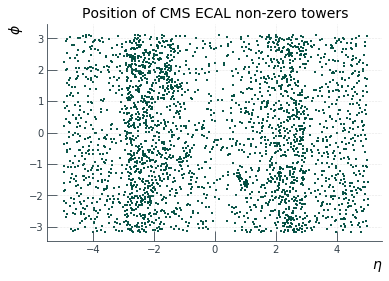

In [6]:
# Placement of non-zero towers in an example event

file = uproot.open("%s/%s" % (SOURCE_PATH, EXAMPLE_FILE))

print("Number of non-zero towers: %s" % (file['Delphes']['Tower']['Tower.Phi'].array()[0].shape[0]))

plt.xlabel('$\eta$', horizontalalignment='right', x=1.0)
plt.ylabel('$\phi$', horizontalalignment='right', y=1.0)
plt.scatter(file['Delphes']['Tower']['Tower.Eta'].array()[0],
            file['Delphes']['Tower']['Tower.Phi'].array()[0],
            color=color_palette['teal']['shade_900'],
            marker='s', s=1);
plt.title('Position of CMS ECAL non-zero towers')
plt.show();

In order to transform calorimeter energy deposits to an image we need to define grid edges of the continues variables $\phi$ and $\eta$ to map them to pixel coorinates.

In [7]:
# Grid edges

def get_edges_ecal(edge_index, tower, sample_events=1000):
    file = uproot.open("%s/%s" % (SOURCE_PATH, EXAMPLE_FILE))
    
    tower_flag_full_file = file['Delphes']['Tower'][tower].array()       
    edges_full_file = file['Delphes']['Tower']['Tower.Edges[4]'].array()

    global_edges = np.array([], dtype=np.float32)
    
    for i in range(sample_events):
        
        edges_event = edges_full_file[i][tower_flag_full_file[i] > 0]
        
        global_edges = np.append(global_edges, edges_event[:,edge_index])
        global_edges = np.append(global_edges, edges_event[:,edge_index+1])
        
        global_edges = np.unique(global_edges)
        
    return global_edges

edges_eta_ecal = get_edges_ecal(edge_index=0, tower='Tower.Eem')
edges_phi_ecal = get_edges_ecal(edge_index=2, tower='Tower.Eem')

edges_eta_hcal = get_edges_ecal(edge_index=0, tower='Tower.Ehad')
edges_phi_hcal = get_edges_ecal(edge_index=2, tower='Tower.Ehad')

edges_eta_ecal = edges_eta_ecal[(edges_eta_ecal > MIN_ETA) & (edges_eta_ecal < MAX_ETA)]
edges_eta_hcal = edges_eta_hcal[(edges_eta_hcal > MIN_ETA) & (edges_eta_hcal < MAX_ETA)]

print("Same dimension in $\eta$: ", edges_eta_ecal.shape == edges_eta_hcal.shape)
print("Same dimension in $\phi$: ", edges_phi_ecal.shape == edges_phi_hcal.shape)

Same dimension in $\eta$:  False
Same dimension in $\phi$:  True


As shown above, the sizes of the calorimeters are different. We need to address that and resize HCAL grid.

In [8]:
def hcal_resize(indices_eta, indices_phi, energy):
    mask = (indices_eta >= 85) & (indices_eta <= 118)

    energy = np.concatenate(
        [np.repeat(x, 5) if mask[i] else np.array([x]) for i, x
         in enumerate(energy)])
    indices_phi = np.concatenate(
        [np.repeat(x, 5) if mask[i] else np.array([x]) for i, x
            in enumerate(indices_phi)])
    indices_eta = np.concatenate(
        [np.array([e]) if e < 85 else np.array([e + 136])
            if e > 118 else 5*e-340 + np.arange(5) for e in indices_eta])

    return indices_eta, indices_phi, energy

## Generating Input Dataset

Our dataset is generated with Delphes. The goal of Delphesis to allow the simulation of a multipurpose detector for phenomenological studies. The simulation includes a tracking system, embedded into a magnetic field, calorimeters and a muon system. Source: https://arxiv.org/abs/1307.6346

In [9]:
# Plotting calorimeter energy deposit image

def plot_calo_image(labels, data2d, data3d, cal='ECAL'):
    
    offset = 15
    
    fig = plt.figure(figsize=(14.0, 6.0))   
    cmap = matplotlib.cm.viridis

    # 3D Plot Energy Deposit
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    eta, phi, energy = data3d
    colours = matplotlib.cm.viridis(energy/np.log10(max(energy)))
    width = depth = .3
    ax.bar3d(eta,
             phi,
             np.zeros_like(energy),
             width,
             depth,
             energy,
             color=colours,
             shade=True)
    ax.set_xlabel('$\phi [\degree$]')
    ax.set_ylabel('$\eta$')
    ax.set_zlabel('$E_T$ [GeV]')
    ax.view_init(10, 40);
    
    ax = fig.add_subplot(1, 2, 2)
    
    ax.text(0,
         1.05,
         "CMS",
         weight='bold',
         verticalalignment="top",
         horizontalalignment="left",
         transform=ax.transAxes,
         color="black",
         fontsize=16)

    ax.set_title('%s $E_T$ with tagged jets' % cal, loc="right")
    
    ax.set_xlim([-offset, data2d.shape[1]+offset])
    ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
    ax.set_ylim([-offset, data2d.shape[0]+offset])
    ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)

    im = ax.imshow(data2d,
                    norm=SymLogNorm(linthresh=0.03,
                                    vmin=0,
                                    vmax=data2d.max()),
                    interpolation="nearest",
                    cmap=cmap)
    
    for label in labels:

        jet = patches.Rectangle((label[1], label[2]),
                                label[3]-label[1],
                                label[4]-label[2],
                                linewidth=2,
                                edgecolor=color_palette['red']['shade_600'],
                                facecolor='none')
        ax.add_patch(jet)
        ax.text(label[1],
                 label[4],
                 '{}: {:.0f} GeV/c'.format(label[0], label[5]),
                 weight='bold',
                 color='#FAFAFA',
                 bbox={'facecolor': color_palette['red']['shade_900'], 'alpha': 1.0})

    cbar = fig.colorbar(im, extend='max')
    cbar.set_label('$E_T$ [GeV]', rotation=90, horizontalalignment='right', y=1.0)

    plt.show();

In [10]:
def get_energy_map(etas, phis, cal='ECAL'):

    if cal == 'ECAL':
        edges_phi = edges_phi_ecal
        edges_eta = edges_eta_ecal
    if cal == 'HCAL':
        edges_phi = edges_phi_hcal
        edges_eta = edges_eta_hcal

    indices_phi = np.squeeze([np.where(edges_phi == i) for i in phis])
    indices_eta = np.squeeze([np.where(edges_eta == i) for i in etas])

    return indices_eta, indices_phi

In [11]:
def get_labels(bbox_pts, bbox_etas, bbox_phis, jtype):

    labels = []

    for pt, eta, phi in zip(bbox_pts, bbox_etas, bbox_phis):

        if pt > MIN_PT[jtype]:
            
            index_eta = np.argmax(edges_eta_ecal >= eta) - 1
            index_phi = np.argmax(edges_phi_ecal >= phi) - 1 #+ offset_phi

            xmin = int(index_eta-JET_RADIUS_IN_PIXELS/2)
            xmax = int(index_eta+JET_RADIUS_IN_PIXELS/2)
            ymin = int(index_phi-JET_RADIUS_IN_PIXELS/2)
            ymax = int(index_phi+JET_RADIUS_IN_PIXELS/2)

            labels.append([jtype, xmin, ymin, xmax, ymax, pt])

    return labels

In [12]:
# Plot examples of input data

def data_generator(file_path, jtype, no_events=1):

    # First load values from file
    file = uproot.open(file_path)
    
    towers = file['Delphes']['Tower']
    tracks = file['Delphes']['Track']
    
    ecal_energy_full_file = towers['Tower.Eem'].array()  # ECAL E
    hcal_energy_full_file = towers['Tower.Ehad'].array()  # HCAL E
    edges_full_file = towers['Tower.Edges[4]'].array()  # Crystal edge
    
    tracker_pt_full_file = tracks['Track.PT'].array()  # ECAL pt
    tracker_eta_full_file = tracks['Track.Eta'].array()  # ECAL eta
    tracker_phi_full_file = tracks['Track.Phi'].array()  # ECAL phi
    
    bbox_pt_full_file = file['Delphes']['GenJet']['GenJet.PT'].array() # Jet PT
    bbox_eta_full_file = file['Delphes']['GenJet']['GenJet.Eta'].array() # Jet x
    bbox_phi_full_file = file['Delphes']['GenJet']['GenJet.Phi'].array() # Jet y
    
    for event_number in np.arange(no_events, dtype=int):

        # Get jet labels: a simplified (not 100% correct version)
        # The verbose version in hdf5-generator.py
        bbox_etas = bbox_eta_full_file[event_number]
        bbox_phis = bbox_phi_full_file[event_number]
        
        etas_mask = (bbox_etas > edges_eta_ecal[0]) & (bbox_etas < edges_eta_ecal[-1])
        
        bbox_etas = bbox_etas[etas_mask]
        bbox_phis = bbox_phis[etas_mask]
        bbox_pts = bbox_pt_full_file[event_number][etas_mask]

        labels = get_labels(bbox_pts, bbox_etas, bbox_phis, jtype)

        # Get ECAL image
        ecal_mask = ecal_energy_full_file[event_number] > 0

        etas = edges_full_file[event_number][ecal_mask][:, 0]
        phis = edges_full_file[event_number][ecal_mask][:, 2]
        energy = ecal_energy_full_file[event_number][ecal_mask]

        etas_mask = ((etas > edges_eta_ecal[0]) &
                     (etas < edges_eta_ecal[-1]))

        etas, phis, ecal_energy = etas[etas_mask], phis[etas_mask], energy[etas_mask]
        ecal_etas, ecal_phis = get_energy_map(etas, phis, cal='ECAL')

        pixels = np.zeros((len(edges_phi_ecal)-1, len(edges_eta_ecal)-1))
        pixels[ecal_phis, ecal_etas] = ecal_energy
        
        plot_calo_image(labels, pixels, (ecal_etas, ecal_phis, ecal_energy), cal='ECAL')

        # Get HCAL image
        hcal_mask = hcal_energy_full_file[event_number] > 0

        etas = edges_full_file[event_number][hcal_mask][:, 0]
        phis = edges_full_file[event_number][hcal_mask][:, 2]
        energy = hcal_energy_full_file[event_number][hcal_mask]

        etas_mask = ((etas > edges_eta_hcal[0]) &
                     (etas < edges_eta_hcal[-1]))

        etas, phis, hcal_energy = etas[etas_mask], phis[etas_mask], energy[etas_mask]
        hcal_etas, hcal_phis = get_energy_map(etas, phis, cal='HCAL')
        hcal_etas, hcal_phis, hcal_energy = hcal_resize(hcal_etas, hcal_phis, hcal_energy)

        pixels = np.zeros((len(edges_phi_ecal)-1, len(edges_eta_ecal)-1))
        pixels[hcal_phis, hcal_etas] = hcal_energy

        plot_calo_image(labels, pixels, (hcal_etas, hcal_phis, hcal_energy), cal='HCAL')
        
        # Get Tracker image
        etas = tracker_eta_full_file[event_number]
        phis = tracker_phi_full_file[event_number]
        pt = tracker_pt_full_file[event_number]
        
        etas_mask = ((etas > edges_eta_ecal[0]) &
                     (etas < edges_eta_ecal[-1]))

        etas, phis, pt = etas[etas_mask], phis[etas_mask], pt[etas_mask]
        pixels = np.histogram2d(phis, etas, bins=[edges_phi_ecal, edges_eta_ecal], weights=pt)[0]
        plot_calo_image(labels, pixels, (etas, phis, pt), cal='Tracker')

An example of b jet


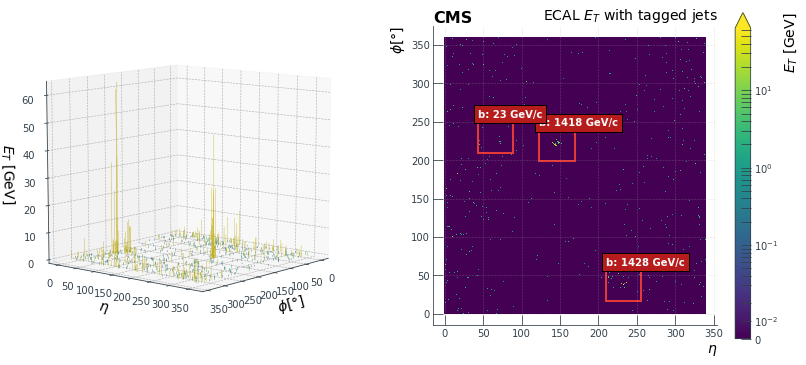

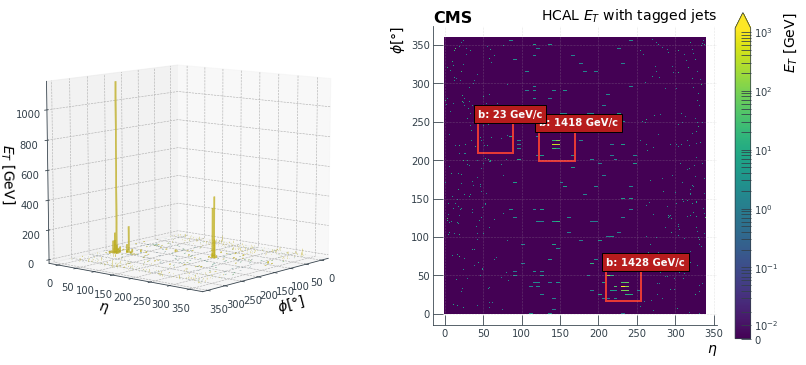

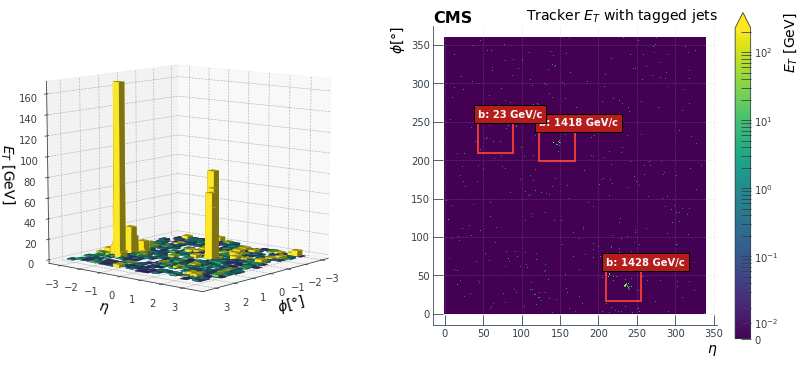

An example of t jet


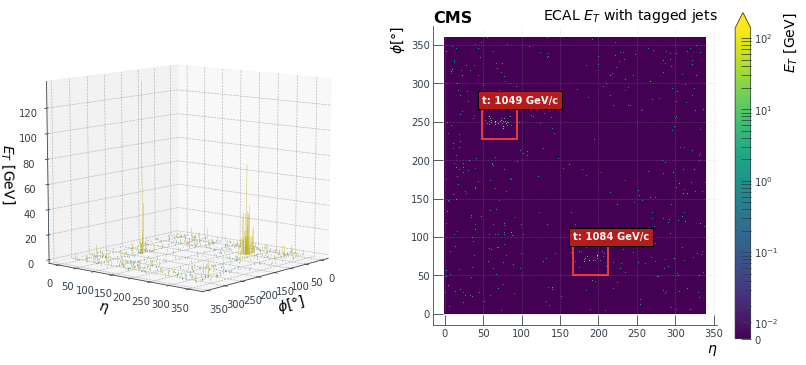

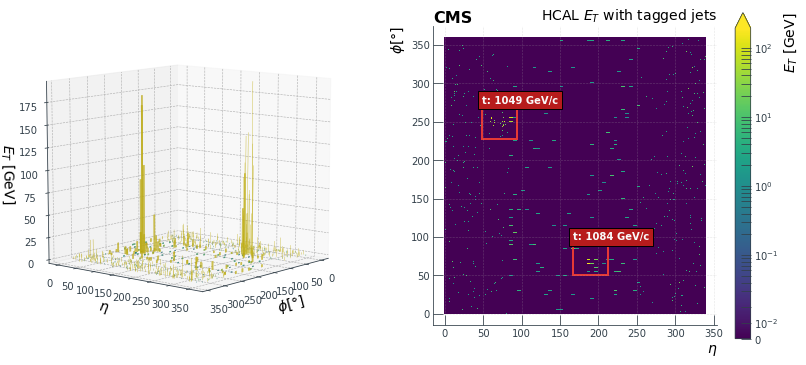

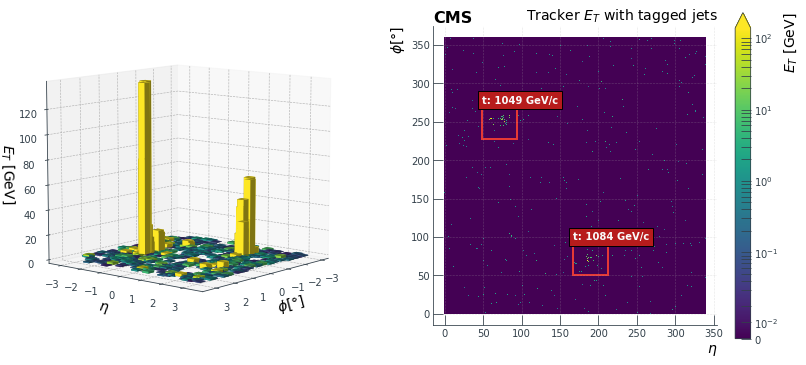

An example of h jet


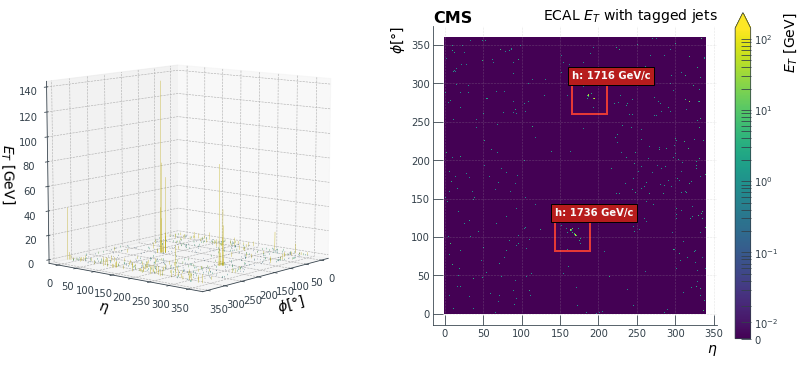

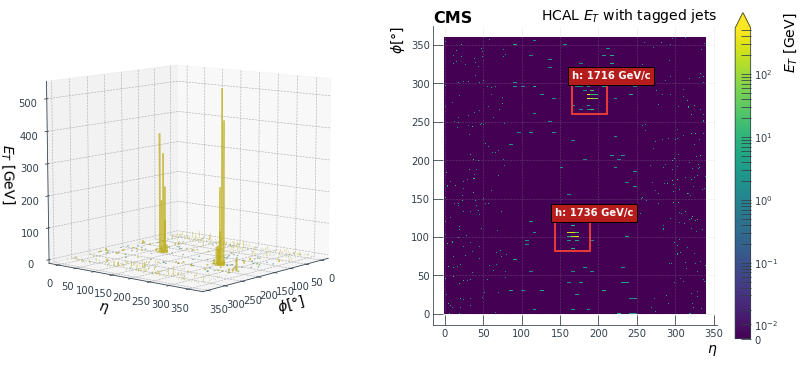

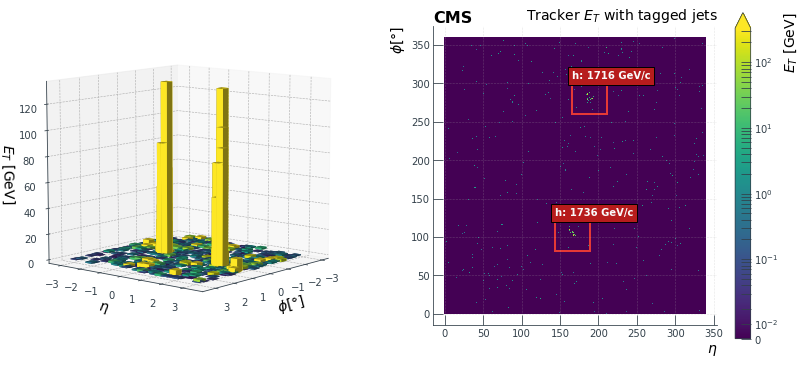

An example of W jet


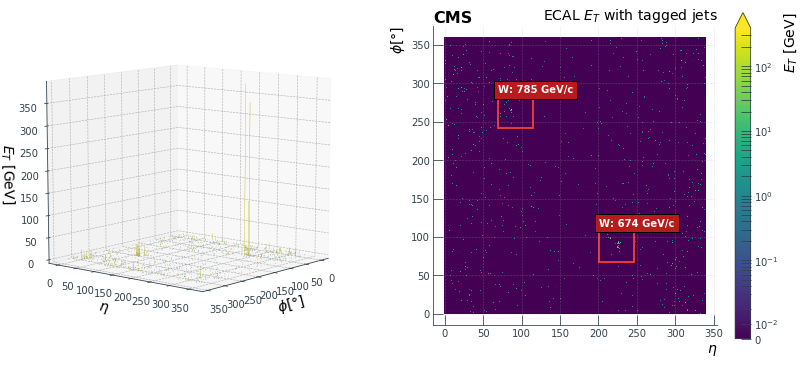

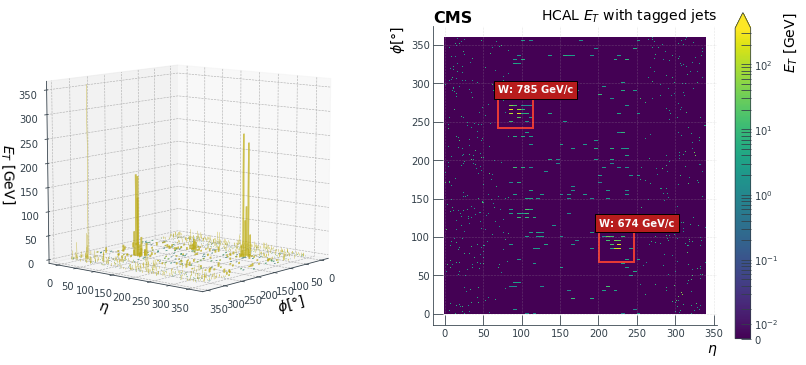

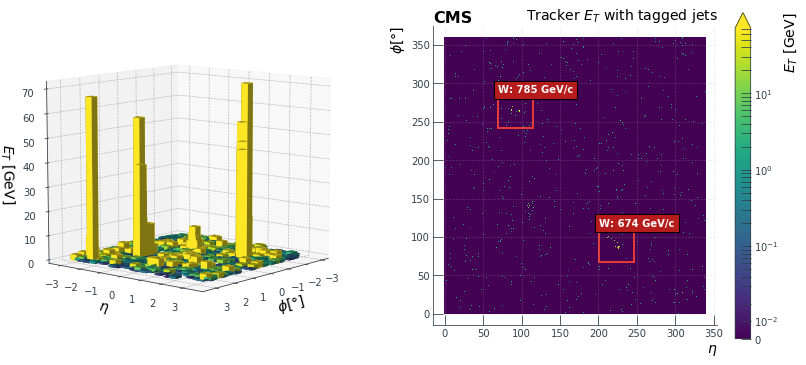

In [13]:
for jtype in ['bb','tt','hh', 'WW']:
    print('An example of %s jet' % jtype[0])
    file_name = "%s/RSGraviton_%s_NARROW/RSGraviton_%s_NARROW_0.root" % (SOURCE_PATH, jtype, jtype)
    data_generator(file_name, jtype[0])